In [58]:
# importing packages 
import numpy as np
import emcee
import corner

from scipy.optimize import least_squares
from matplotlib import pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = "retina"

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
#rcParams["font.size"] = 5


# importing functions
from functions_part2 import E_from_M
from functions_part2 import generate_pm_signal
from functions_part2 import generate_parallax_signal
from functions_part2 import thiele_innes
from functions_part2 import generate_planet_signal
from functions_part2 import generate_astrometry_signal

# unit conversion 
rad_mas = 206264806

# times 
times = np.linspace(0, 4.2, 60)

#a_hat = 8.215324703170904e-10

This function takes in pars (parameters) and times and returns the proper motion, parallax, planetary and total singal 

In [59]:
# function takes in paraneters 
def func(pars, times, a_earth = 1):
    alpha, delta, mu_alpha, mu_delta, parallax, omega, Omega, inc, e, a_AU, P_orb, t_peri = pars
    
    a_hat = 0.014116666278885887*a_AU*parallax  # a_hat is not defined correctly
    
    prop_mot_ra, prop_mot_dec = generate_pm_signal(alpha, delta, mu_alpha, mu_delta, times)

    parallax_ra, parallax_dec = generate_parallax_signal(alpha, delta, parallax, times)
    
    planetary_ra, planetary_dec = generate_planet_signal(alpha, delta, omega, Omega, inc, a_AU, parallax, P_orb, t_peri, e, times)
    
    signal_ra  = prop_mot_ra  + parallax_ra  + planetary_ra
    signal_dec = prop_mot_dec + parallax_dec + planetary_dec
    
    return(prop_mot_ra, parallax_ra, planetary_ra, signal_ra, prop_mot_dec, parallax_dec, planetary_dec, signal_dec)

This function takes in parameters, an error and xy data and returns the normalized residuals 

In [60]:
def normalized_residuals(pars, sigma, ra_obs, dec_obs):

    _, _, _, ra_pred, _, _, _, dec_pred = func(pars, times)
    
    d_ra  = ra_obs  - ra_pred
    d_dec = dec_obs - dec_pred
    
    return np.concatenate((d_ra/sigma, d_dec/sigma))

Setting the true parameters 

In [61]:
parameters = ['alpha', 'delta', 'mu_alpha', 'mu_delta', 'parallax', 'omega', 'Omega', 'inc', 'e', 'a_AU', 'P_orb', 't_peri']

alpha_true    = 0.7853981641246757
delta_true    = 0.7853981637587035
mu_alpha_true = 2.3084641853871365e-07
mu_delta_true = 1.770935480191023e-07
parallax_true = 9.699321049402031e-08
omega_true    = 2
Omega_true    = 1
inc_true      = 0.2
e_true        = 0.2
a_AU_true     = 0.6 
P_orb_true    = 0.46146592515998475
t_peri_true   = 0 

truepars = np.array((alpha_true, delta_true, mu_alpha_true, mu_delta_true, parallax_true, omega_true, Omega_true, inc_true, e_true, a_AU_true, P_orb_true, t_peri_true))

Using true parameters to create true data and adding some noise/error to that data to make the observed data 

In [62]:
pm_ra_true, prlx_ra_true, true_plnt_ra, true_ra, pm_dec_true, prlx_dec_true, true_plnt_dec, true_dec = func(truepars, times)

sigma_err = (1e-5*np.pi/180/60/60)*5

# yobs is equal to ytrue + some noise
ra_obs  = true_ra   +  np.random.normal(0, sigma_err, len(true_ra)) 
dec_obs = true_dec  +  np.random.normal(0, sigma_err, len(true_dec)) 

Making a guess for the parameteres based on the true data plus some random constant within 0-0.01

In [63]:
np.random.seed(36)
constant = np.random.uniform(0,0.01)
guess = truepars * (1 + constant)

Using least_squares to do a least squares fit using the observed data and guess parameters to calculate the parameters (result_LS.x) which are then using in func to create data 

In [64]:
from scipy.optimize import leastsq

In [65]:
best,cov,_,_,_=leastsq(normalized_residuals, guess, args=(sigma_err, ra_obs, dec_obs),full_output=1)

In [66]:
best

array([7.85398164e-01, 7.85398164e-01, 2.30873888e-07, 1.77107147e-07,
       9.69890409e-08, 2.05691681e+00, 9.71364137e-01, 2.05190240e-01,
       1.91923896e-01, 5.96570008e-01, 4.61014086e-01, 5.98736111e-03])

In [67]:
# LS fit
result_LS = least_squares(normalized_residuals, guess, args=(sigma_err, ra_obs, dec_obs)) 

# data from best fit 
_, _, best_plnt_ra, best_ra, _, _, best_plnt_dec, best_dec = func(best, times)# func(result_LS.x, times)

Printing the parameters calculated in result_LS and plotting the true and best data for planetary and full signal

In [69]:
cov

Lest-squares estimates:
alpha = 0.7853981640847203
delta = 0.7853981637509291
mu_alpha = 2.3087506209194473e-07
mu_delta = 1.7710249131325703e-07
parallax = 9.69894005435749e-08
omega = 2.0820473645646285
Omega = 0.9680907725782862
inc = 0.2484871491689353
e = 0.14745281342936498
a_AU = 0.6180402923748834
P_orb = 0.4604041263600831
t_peri = 0.009406998783434312


Text(0.5, 1.0, 'Signal')

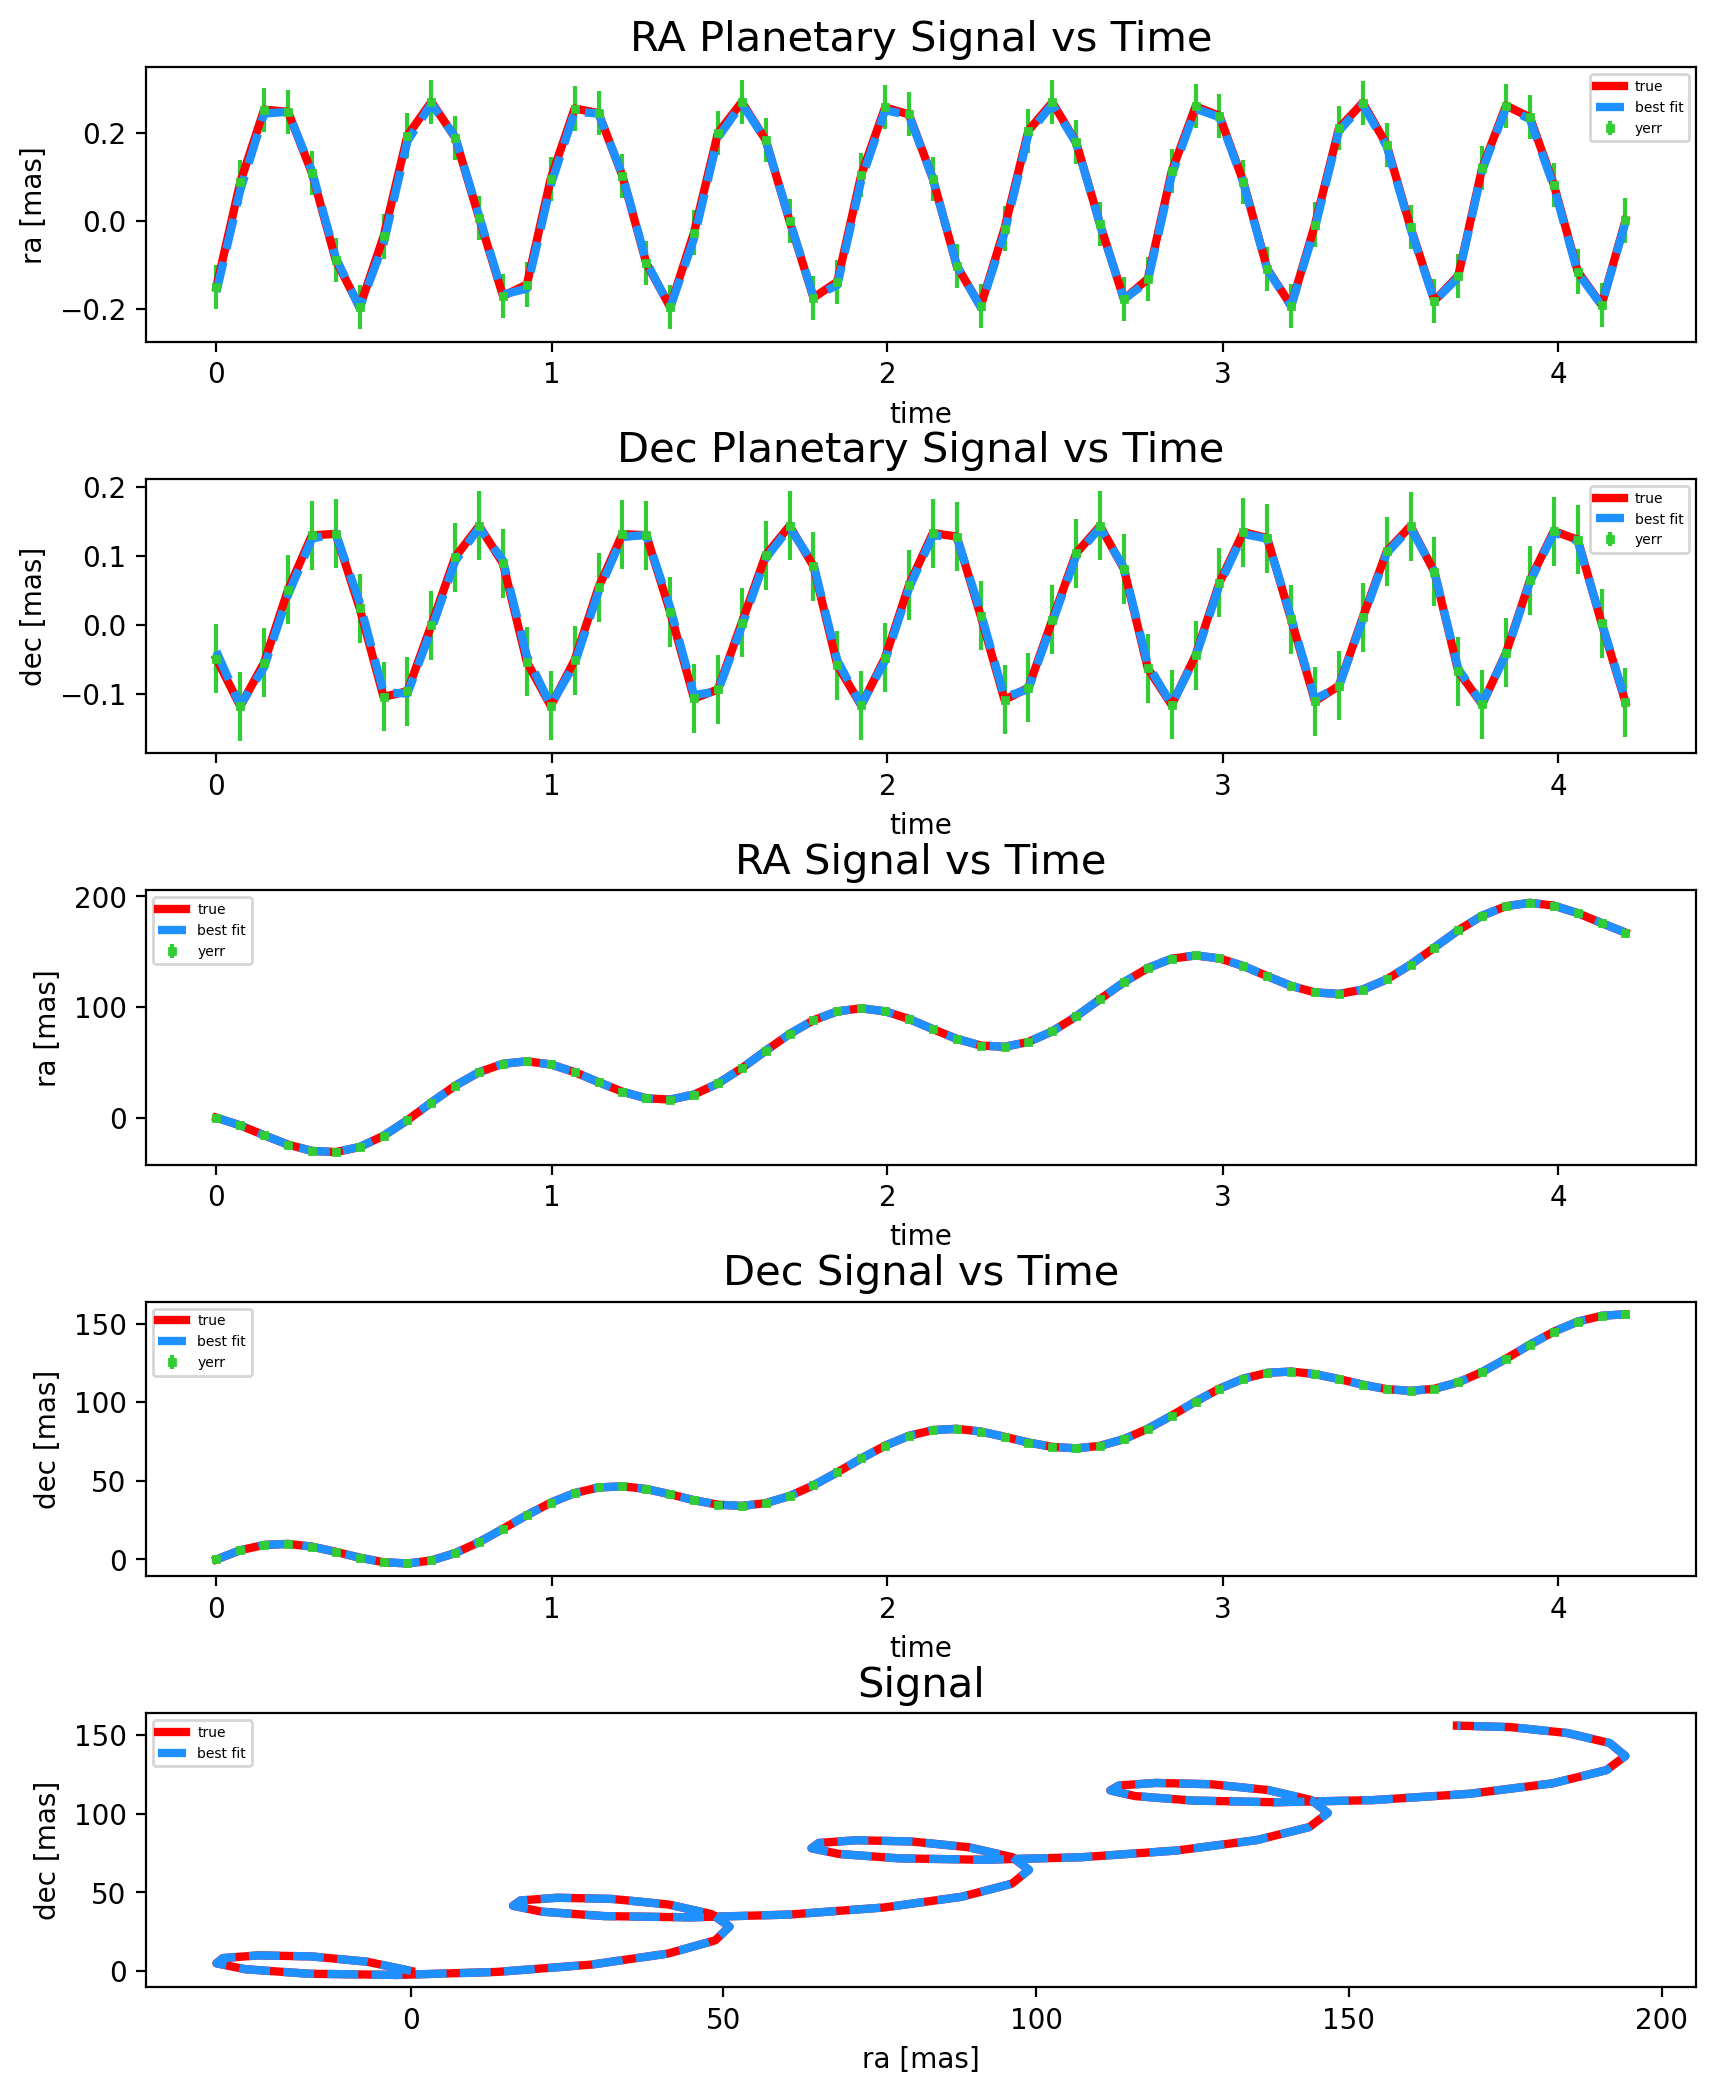

In [68]:
# printing the parameters that the LS fit calculated 
print("Lest-squares estimates:")
for i in range(0, len(parameters)):
    print(parameters[i], '=', result_LS.x[i])

fig, ax = plt.subplots(5, 1, figsize=(10, 12), sharex=False)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

ax[0].errorbar(times, (true_plnt_ra)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[0].plot(times, (true_plnt_ra)*rad_mas, lw=3, color='red', label='true')
ax[0].plot(times, (best_plnt_ra)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[0].legend(fontsize=5)
ax[0].set_xlabel("time", fontsize = 10)
ax[0].set_ylabel("ra [mas]", fontsize = 10)
ax[0].set_title("RA Planetary Signal vs Time", fontsize = 15)

ax[1].errorbar(times, (true_plnt_dec)*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[1].plot(times, (true_plnt_dec)*rad_mas, lw=3, color='red', label='true')
ax[1].plot(times, (best_plnt_dec)*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[1].legend(fontsize=5)
ax[1].set_xlabel("time", fontsize = 10)
ax[1].set_ylabel("dec [mas]", fontsize = 10)
ax[1].set_title("Dec Planetary Signal vs Time", fontsize = 15)

ax[2].errorbar(times, (true_ra-true_ra[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[2].plot(times, (true_ra-true_ra[0])*rad_mas, lw=3, color='red', label='true')
ax[2].plot(times, (best_ra-best_ra[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--')
ax[2].legend(fontsize=5)
ax[2].set_xlabel("time", fontsize = 10)
ax[2].set_ylabel("ra [mas]", fontsize = 10)
ax[2].set_title("RA Signal vs Time", fontsize = 15)

ax[3].errorbar(times, (true_dec-true_dec[0])*rad_mas, yerr=sigma_err*rad_mas, fmt="s", markersize=2, color='limegreen', label='yerr')
ax[3].plot(times, (true_dec-true_dec[0])*rad_mas, lw=3, color='red', label='true')
ax[3].plot(times, (best_dec-best_dec[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[3].legend(fontsize=5)
ax[3].set_xlabel("time", fontsize = 10)
ax[3].set_ylabel("dec [mas]", fontsize = 10)
ax[3].set_title("Dec Signal vs Time", fontsize = 15)

ax[4].plot((true_ra-true_ra[0])*rad_mas, (true_dec-true_dec[0])*rad_mas, lw=3, color='red', label='true')
ax[4].plot((true_ra-best_ra[0])*rad_mas, (best_dec-best_dec[0])*rad_mas, lw=3, color='dodgerblue', label='best fit', ls='--', )
ax[4].legend(fontsize=5)
ax[4].set_xlabel("ra [mas]", fontsize = 10)
ax[4].set_ylabel("dec [mas]", fontsize = 10)
ax[4].set_title("Signal", fontsize = 15)

### Maximum likelihood estimation 

In [11]:
def log_likelihood(pars, x, y, yerr):
    
    values_list = normalized_residuals(pars, yerr, x, y)
    
    return -0.5*(values_list @ values_list)

### Marginalization & uncertainty estimation

Function takes in parameters, if they are within certain bounds it will either return 0 or -$\infty$

In [35]:
result_LS.x[-5],result_LS.x[6]

# section 5 

(-0.041564578124493275, -0.24721655842040352)

In [71]:
def log_prior(pars):
    alpha, delta, mu_alpha, mu_delta, parallax, omega, Omega, inc, e, a_AU, P_orb, t_peri = pars 
    
#     if not x < alpha < y:
#         return -np.inf
    
#     if not x < delta < y:
#         return -np.inf
    
#     if not x < mu_alpha < y:
#         return -np.inf
    
#     if not x < mu_delta < y:
#         return -np.inf
    
    if not 0 < parallax:
        return -np.inf
        
    if not 0 < e < 1:
        return -np.inf
    
    if not 0 < a_AU:
        return -np.inf
    if not 0 < P_orb:
        return -np.inf
    if not -0.5 * P_orb < t_peri <= 0.5 * P_orb:
        return -np.inf
    
    return 0.0

In [72]:
result_LS.x

array([7.85398164e-01, 7.85398164e-01, 2.30875062e-07, 1.77102491e-07,
       9.69894005e-08, 2.08204736e+00, 9.68090773e-01, 2.48487149e-01,
       1.47452813e-01, 6.18040292e-01, 4.60404126e-01, 9.40699878e-03])

Fucntion takes in parameters, x aand y data and y error and if log_prior(pars) is not finite it will return $-\infty$ and if it is finite it will return $log\_prior(pars)+log\_likelihood(pars, x, y, yerr)$

In [38]:
def log_probability(pars, x, y, yerr):
    lp = log_prior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(pars, x, y, yerr)

pos is an array of the parameters found in the LS fit plus some number with 32 different numbers

In [39]:
log_likelihood(result_LS.x, true_ra, true_dec, sigma_err)

-5.337484629135119

In [40]:
log_prior(result_LS.x)

0.0

In [41]:
log_probability(result_LS.x, true_ra, true_dec, sigma_err)

-5.337484629135119

In [42]:
np.random.seed(23)
pos = result_LS.x*(1+1e-4 * np.random.randn(32, 12)) 
nwalkers, ndim = pos.shape

check = np.isfinite([log_probability(z, true_ra, true_dec, sigma_err) for z in pos])
check 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [43]:
initials_good = np.alltrue(np.isfinite([log_probability(z, true_ra, true_dec, sigma_err) for z in pos]))
assert initials_good

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(true_ra, true_dec, sigma_err)
)
sampler.run_mcmc(pos, 5000, progress = True);

100%|███████████████████████████████████████| 5000/5000 [00:56<00:00, 88.47it/s]


Plot value calculated vs step number for each of the parametes

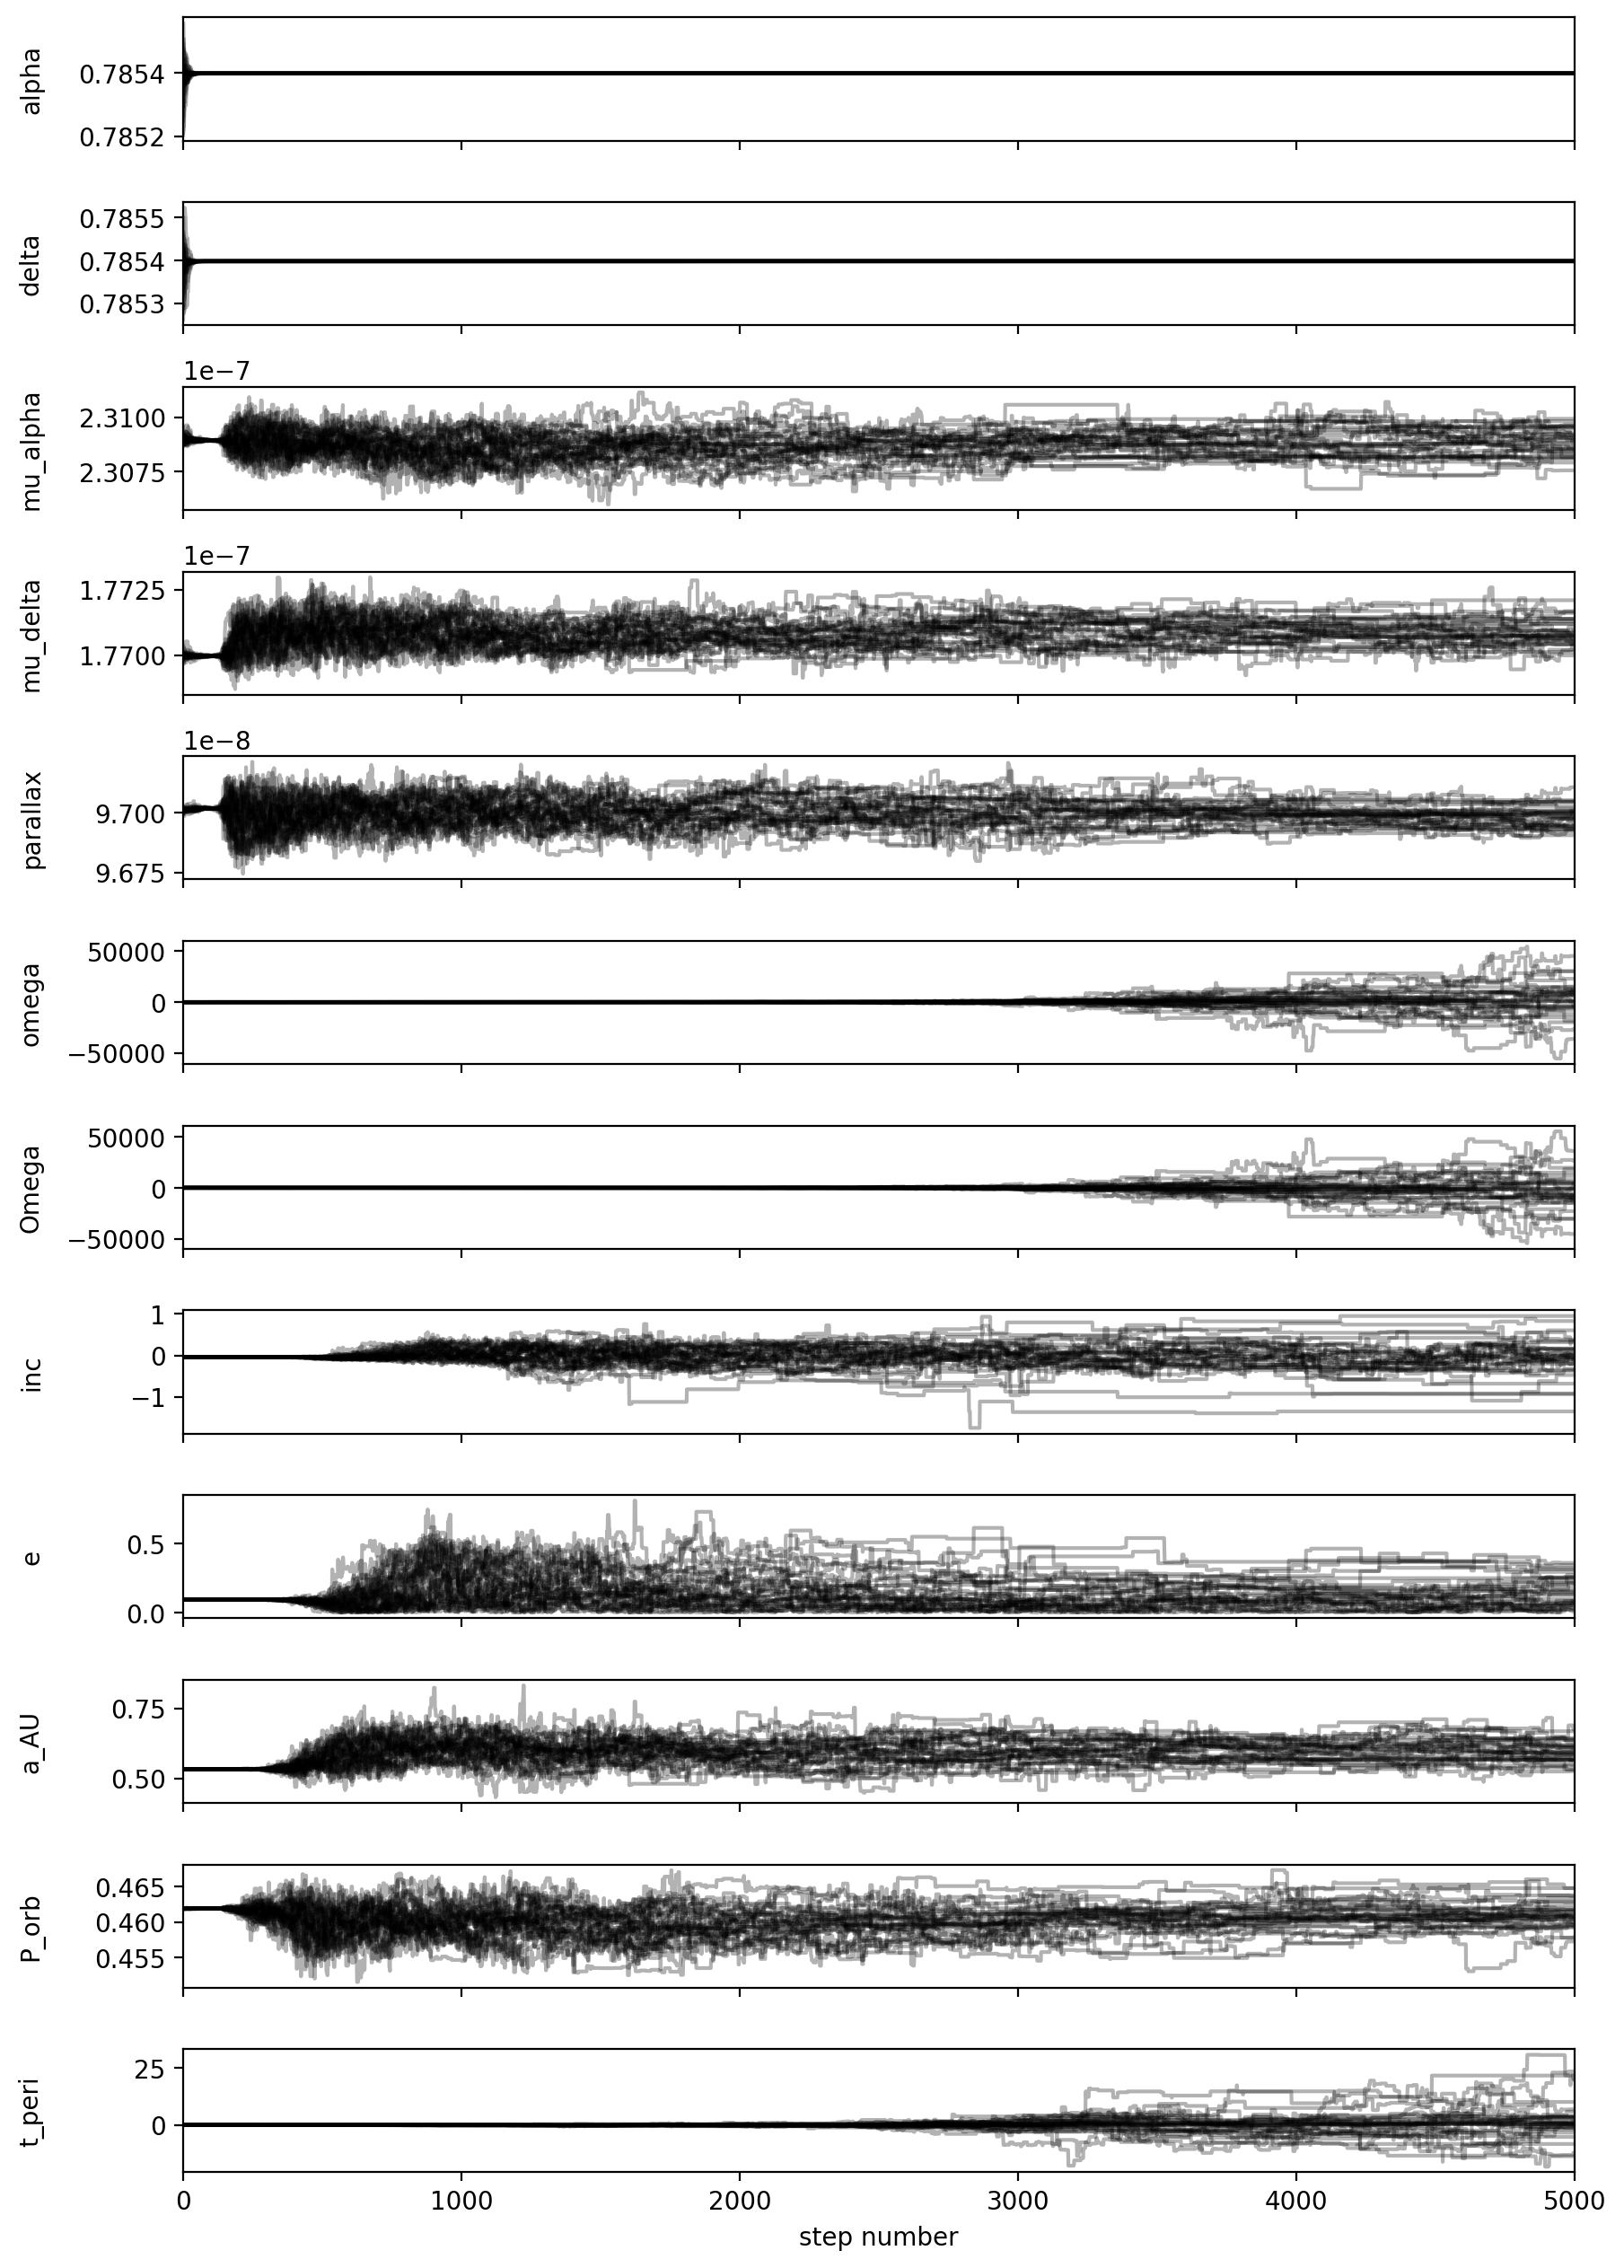

In [44]:
fig, axes = plt.subplots(12, figsize=(10, 15), sharex=True)
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)

samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Estimate the integrated autocorrelation

In [70]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [ 14.41022412  14.71927573 420.28597894 305.62433415 351.81897051
 522.2314993  522.12455059 430.96257948 375.36721078 357.94784247
 354.03473097 509.17744412]

Flatten the chain so we have a flat list of samples 

In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(4032, 12)


# Results

Make a corner plot to show MCMC results 

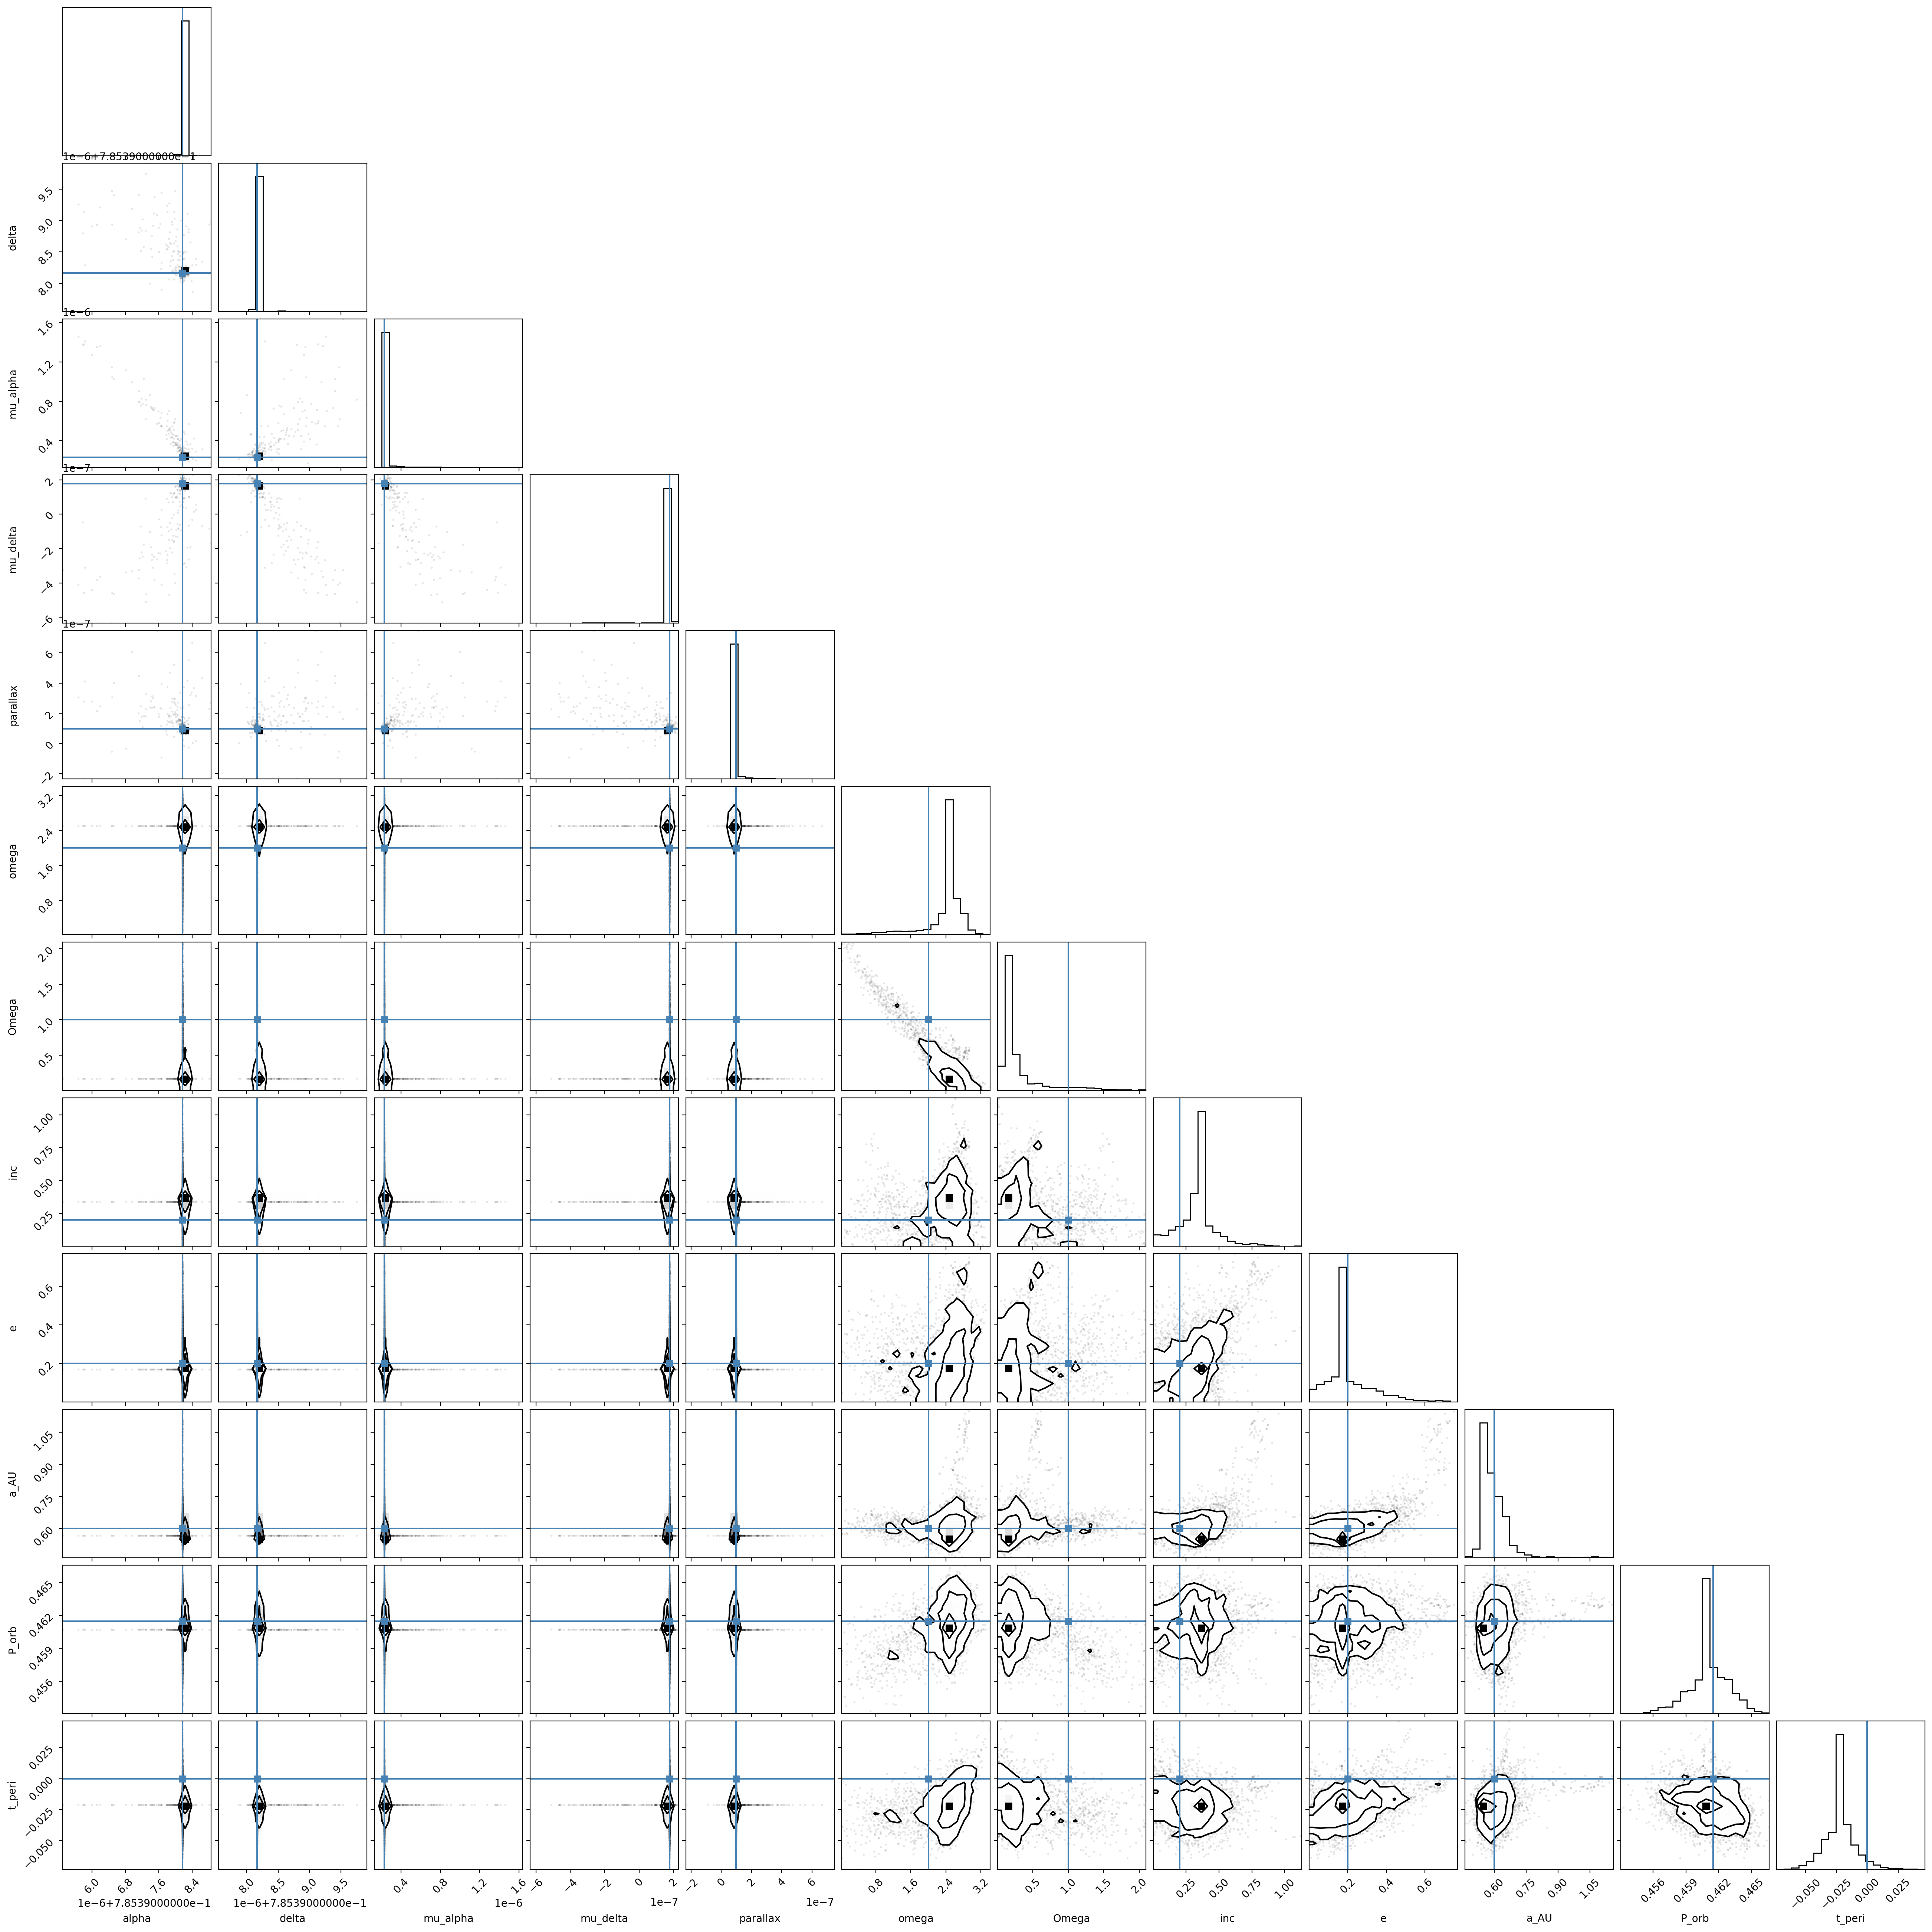

In [19]:
fig = corner.corner(
    flat_samples, labels=parameters, truths=truepars
);